# Project 4

## Group Number 6

### Team Members
- Baraa Nidal Ghannoum
- Tom Mantel
- Mubarik Omar Ali Abdi


Abstract:
The main purpose of project 4 is to understand and apply supervised and unsupervised machine learning into scientifical applications such as analysis of astronomical cluster images, and the study of epidemiology.

Topic 1 dwelss on unsupervised learning through the use of the milky way cluster image. By converting the sky map imgaes into numerical RGB arrays (red, green, and blue pixels). One can observe through different clustering techniques how a galaxy is structured.

Topic 2 involves supervised learning by creating a model of the ebola outbreak. Several predictive methods are implimented such as linear regression, neural network (NN), and LSTM architecture. These methods are meant to further the understanding on how an outbreak like Ebola can further evolve.


Intro:
Machine learning is a tool used in relation with artificial intelligience, by creating algorithms which have the ability to adapt to patterns based on established data [1]. The application of machine learning is a new method for data analysts to understand complex systems, and develop usefull models or predicting future outcomes. In todays world, the more traditional method of analytical techniques does not always bring accurate results.

In the field of AI, machine learning has already become a resourceful tool for occupations like weather forecasting, to production of self driven vechiles [1]. Project 4 involves how supervised and unsupervised machine learning can be applied in regards of mapping of celestial vodies to predicting the evolution of an epidemic.

Topic 1

Task 0

In [2]:
# Task 0: Install mw_plot library
!pip install mw_plot


In [3]:
import mw_plot
print("mw_plot successfully installed and imported!")
#to make srure the library is installed and working 


mw_plot successfully installed and imported!


Task 1

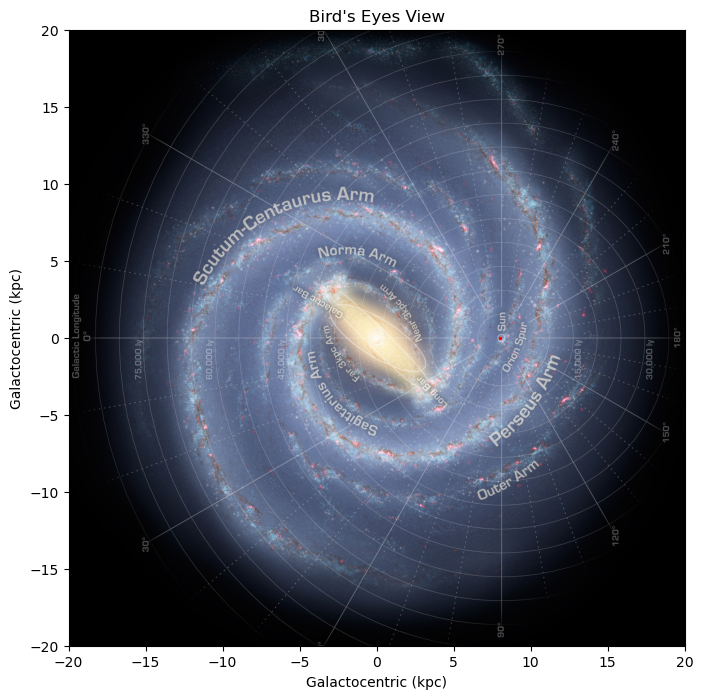

In [4]:
# Task 1: Create a simple plot using mw_plot
import numpy as np
from astropy import units as u
from mw_plot import MWFaceOn

mw1 = MWFaceOn(
    radius=20 * u.kpc,
    unit=u.kpc,
    coord="galactocentric",
    annotation=True,
    figsize=(10, 8),
)


mw1.title = "Bird's Eyes View"
mw1.scatter(8 * u.kpc, 0 * u.kpc, c="r", s=2)
#this is directly taken form the wepbag of mw_plot see resource number 4 



Task 2

As we need to measure the brightness of the galaxy at different radiuses, we go to data reduction, aka 2-D to 1-D curves. We convert the RGB into luminance, and convert the pixel positions to galactrocenctric coordinates, which should in the end showcase a graph coresponding brightness vs radius.

min: 0 max: 255


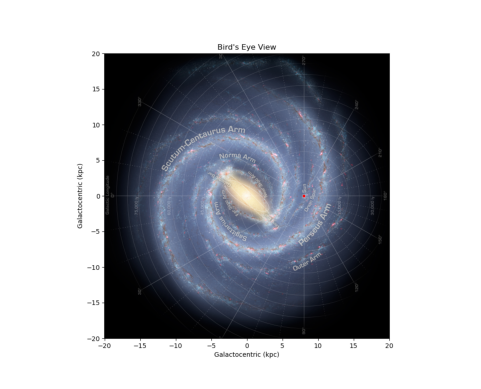

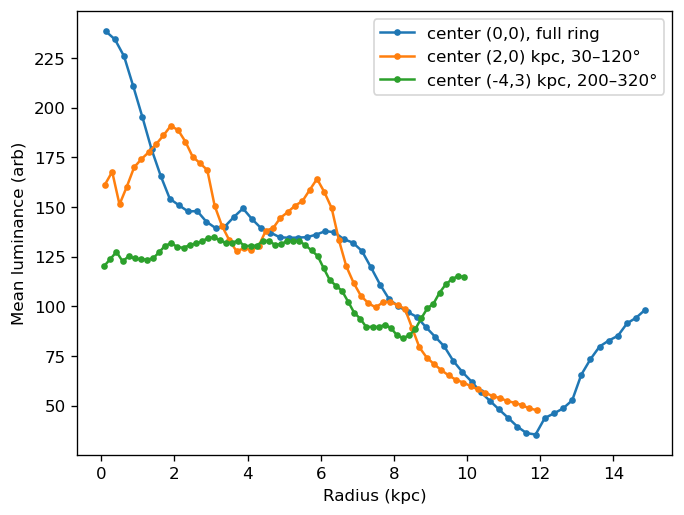

In [5]:


# Task 2: building the visualizations

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from mw_plot import MWFaceOn
from matplotlib.colors import rgb_to_hsv

def render_faceon(radius=20*u.kpc, figsize=(10,8)):
    # Let MWFaceOn create and use its own figure, like in Task 1
    mw = MWFaceOn(
        radius=radius,
        unit=u.kpc,
        coord="galactocentric",
        annotation=True,
        figsize=figsize,
    )

    mw.title = "Bird's Eye View"
    mw.scatter(8*u.kpc, 0*u.kpc, c="r", s=10)

    # Get the figure MWFaceOn is actually using
    fig = plt.gcf()
    fig.canvas.draw()

    # Read pixels from that figure
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    img_rgba = buf.reshape(h, w, 4)

    # Drop alpha → RGB
    img = img_rgba[..., :3].copy()

    plt.close(fig)

    extent = (-radius.value, radius.value, -radius.value, radius.value)
    return img, extent

def radial_profile_sector(rgb, extent, center=(0,0), rmax=12.0, nrbins=60,
                          theta_deg=(0, 360)):
    # colour -> grayscale
    lum = (0.2126*rgb[...,0] + 0.7152*rgb[...,1] + 0.0722*rgb[...,2]).astype(float)

    xmin, xmax, ymin, ymax = extent
    h, w = lum.shape
    xs = np.linspace(xmin, xmax, w)
    ys = np.linspace(ymin, ymax, h)
    X, Y = np.meshgrid(xs, ys)

    xc, yc = center
    R = np.sqrt((X-xc)**2 + (Y-yc)**2)
    T = (np.degrees(np.arctan2(Y-yc, X-xc)) + 360) % 360

    t1, t2 = theta_deg
    if t1 <= t2:
        sector = (T>=t1) & (T<=t2)
    else:
        sector = (T>=t1) | (T<=t2)

    r_edges = np.linspace(0, rmax, nrbins+1)
    prof = np.zeros(nrbins)
    for i in range(nrbins):
        mask = (R>=r_edges[i]) & (R<r_edges[i+1]) & sector
        prof[i] = lum[mask].mean() if np.any(mask) else np.nan
    r_centers = 0.5*(r_edges[:-1] + r_edges[1:])
    return r_centers, prof


# rendering the image once
rgb_array, extent = render_faceon(radius=20*u.kpc)

print("min:", rgb_array.min(), "max:", rgb_array.max())
plt.imshow(rgb_array); plt.axis("off"); plt.show()

# three different profiles (different centers, radiuses, sectors)
configs = [
    {"center":(0,0),   "rmax":15, "theta_deg":(0,360),  "label":"center (0,0), full ring"},
    {"center":(2,0),   "rmax":12, "theta_deg":(30,120), "label":"center (2,0) kpc, 30–120°"},
    {"center":(-4,3),  "rmax":10, "theta_deg":(200,320),"label":"center (-4,3) kpc, 200–320°"},
]

plt.figure(dpi=120)

for cfg in configs:
    cfg_clean = {k: v for k, v in cfg.items() if k != "label"}
    r, y = radial_profile_sector(rgb_array, extent, **cfg_clean)
    plt.plot(r, y, marker=".", label=cfg["label"])

plt.xlabel("Radius (kpc)")
plt.ylabel("Mean luminance (arb)")
plt.legend()
plt.show()

Task 3

We will capture and render figures directly from matplotlib, and it will return a numpy array representing the image.

In [6]:
# Do note that we need the rgb array to be named as rgb_array for the code to work

#calling the renderer from task 2 into the code

rgb_array, extent = render_faceon(radius=20*u.kpc)
print(rgb_array.shape, rgb_array.dtype)

(800, 1000, 3) uint8


Task 4

Each RGB channel (0–255) is broken into 4 ranges

Every pixel gets mapped to a category number (0 to 63)

In [7]:
# A

def color_bins(rgb, k=4):
    # rgb is advised to be in the uint8 format.
    bins = np.linspace(0, 256, k+1)
    r = np.digitize(rgb[...,0], bins) - 1
    g = np.digitize(rgb[...,1], bins) - 1
    b = np.digitize(rgb[...,2], bins) - 1
    #this is combined into a single integer label
    labels = (r * k + g) * k + b
    return labels

labels_bins = color_bins(rgb_array, k=4)  # categories per channel

Task 5

Image shape: (1200, 1500, 3)


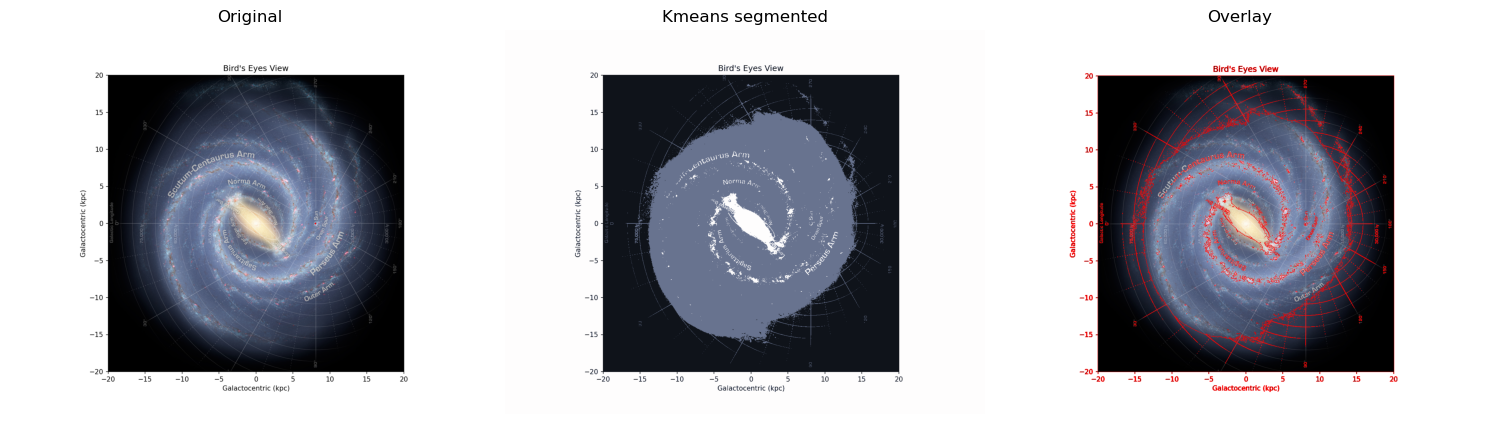

'\n# Task1_5: Apply K-means clustering to Milky Way image data\n\nfrom sklearn.cluster import KMeans\n\ndef render_faceon(radius=20*u.kpc, figsize=(10,8), dpi=150):\n    # Create MWFaceOn \n    mw = MWFaceOn(radius=radius, unit=u.kpc, coord="galactocentric",\n                  annotation=True, figsize=figsize)\n    mw.title = "Bird\'s Eyes View"\n    mw.scatter(8*u.kpc, 0*u.kpc, c="r", s=2)\n\n    # Try to get the figure object used by MWFaceOn\n    fig = getattr(mw, "fig", None) or getattr(mw, "figure", None) or plt.gcf()\n\n    # Ensure size and dpi\n    fig.set_size_inches(figsize)\n    fig.set_dpi(dpi)\n    fig.canvas.draw()\n    \n    # Read RGBA buffer from the correct canvas\n    w, h = fig.canvas.get_width_height()\n    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)\n    img_rgba = buf.reshape(h, w, 4)\n    img_rgb = img_rgba[..., :3].copy()  # shape (H, W, 3), dtype uint8\n\n    # Close the figure to avoid extra notebook outputs\n    plt.close(fig)\n\n    extent

In [9]:
#task1_5:
#apply kmeans clustering to milky way image data
from sklearn.cluster import KMeans


def render_faceon(radius=20*u.kpc, figsize=(10,8), dpi=150):

    # I think this makes the Milky Way thing?!
    mw = MWFaceOn(radius=radius, unit=u.kpc, coord="galactocentric",
                  annotation=True, figsize=figsize)
    mw.title = "Bird's Eyes View"
    mw.scatter(8*u.kpc, 0*u.kpc, c="r", s=2)

    #  so trying a few things to get the fig 
    try:
        fig = mw.fig
    except:
        try:
            fig = mw.figure
        except:
            fig = plt.gcf()

    # resize stuff
    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)

    # draw so we can get pixels
    fig.canvas.draw()

    
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)

    img = buf.reshape(h, w, 4)      # RGBA
    img = img[:, :, :3]             # drop alpha

    plt.close(fig)                  # so we don’t get extra pictures showing up

    # I think this is the extent ??
    ext = (-radius.value, radius.value, -radius.value, radius.value)

    return img, ext


def kmeans_segment_and_overlay(rgb_array, n_clusters=3, subsample=None, show=True):

    h = rgb_array.shape[0]
    w = rgb_array.shape[1]

    # turning image into a list of pixels
    pix = rgb_array.reshape(h*w, 3)
    pix = pix / 255.0   # I think this normalizes??

    # I guess subsampling makes it faster
    if subsample is not None and subsample < len(pix):
        # random stuff
        rng = np.random.default_rng(42)
        idx = rng.choice(len(pix), subsample, replace=False)
        samp = pix[idx]

        km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        km.fit(samp)

        lbls = km.predict(pix)
    else:
        km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        km.fit(pix)
        lbls = km.labels_

    # centers (not sure if this is best way)
    cents = km.cluster_centers_ * 255
    cents = cents.astype(np.uint8)

    seg = cents[lbls]
    seg = seg.reshape(h, w, 3)

    # finding edges kinda manually
    label_img = lbls.reshape(h, w)
    bound = np.zeros((h, w), dtype=bool)

    for i in range(h-1):
        for j in range(w-1):
            if label_img[i, j] != label_img[i, j+1] or label_img[i, j] != label_img[i+1, j]:
                bound[i, j] = True

    over = rgb_array.copy()
    over[bound] = [255, 0, 0]   

    if show:
        plt.figure(figsize=(15, 6))

        plt.subplot(1,3,1)
        plt.imshow(rgb_array)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(seg)
        plt.title("Kmeans segmented")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(over)
        plt.title("Overlay")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return seg, label_img, over


# testing
rgb_array, extent = render_faceon(radius=20*u.kpc)
print("Image shape:", rgb_array.shape)

segmented, labels, overlay = kmeans_segment_and_overlay(rgb_array, n_clusters=3, subsample=100000)



#by using AI this is what ihave got :) 
"""
# Task1_5: Apply K-means clustering to Milky Way image data

from sklearn.cluster import KMeans

def render_faceon(radius=20*u.kpc, figsize=(10,8), dpi=150):
    # Create MWFaceOn 
    mw = MWFaceOn(radius=radius, unit=u.kpc, coord="galactocentric",
                  annotation=True, figsize=figsize)
    mw.title = "Bird's Eyes View"
    mw.scatter(8*u.kpc, 0*u.kpc, c="r", s=2)

    # Try to get the figure object used by MWFaceOn
    fig = getattr(mw, "fig", None) or getattr(mw, "figure", None) or plt.gcf()

    # Ensure size and dpi
    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)
    fig.canvas.draw()
    
    # Read RGBA buffer from the correct canvas
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    img_rgba = buf.reshape(h, w, 4)
    img_rgb = img_rgba[..., :3].copy()  # shape (H, W, 3), dtype uint8

    # Close the figure to avoid extra notebook outputs
    plt.close(fig)

    extent = (-radius.value, radius.value, -radius.value, radius.value)
    return img_rgb, extent

def kmeans_segment_and_overlay(rgb_array, n_clusters=3, subsample=None, show=True):
    # Reshape to (num_pixels, 3)
    h, w, _ = rgb_array.shape
    pixels = rgb_array.reshape(-1, 3).astype(float) / 255.0  # normalize
    
    # Optionally subsample for speed
    if subsample is not None and subsample < pixels.shape[0]:
        rng = np.random.default_rng(42)
        sample_idx = rng.choice(pixels.shape[0], size=subsample, replace=False)
        sample = pixels[sample_idx]
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(sample)
        labels = kmeans.predict(pixels)
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(pixels)
        labels = kmeans.labels_

    # Build segmented image using cluster centers as colors
    centers = (kmeans.cluster_centers_ * 255).astype(np.uint8)
    segmented = centers[labels].reshape(h, w, 3)

    # Build label image and compute simple boundaries
    label_img = labels.reshape(h, w)
    boundary = np.zeros((h, w), dtype=bool)
    boundary[:, :-1] |= label_img[:, :-1] != label_img[:, 1:]
    boundary[:-1, :] |= label_img[:-1, :] != label_img[1:, :]

    # Overlay boundaries on original (red lines)
    overlay = rgb_array.copy().astype(np.uint8)
    overlay[boundary] = np.array([255, 0, 0], dtype=np.uint8)

    
    if show:
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))
        axes[0].imshow(rgb_array)
        axes[0].set_title("Original")
        axes[0].axis("off")

        axes[1].imshow(segmented)
        axes[1].set_title(f"Segmented (KMeans, k={n_clusters})")
        axes[1].axis("off")

        axes[2].imshow(overlay)
        axes[2].set_title("Original + cluster boundaries")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    return segmented, label_img, overlay
# Example usage:
# 1) Render the face-on image (no extra empty figures)
rgb_array, extent = render_faceon(radius=20*u.kpc)
print("Rendered image shape:", rgb_array.shape, "dtype:", rgb_array.dtype)

# 2) Segment with KMeans (use subsample for large images, e.g., subsample=100000)
segmented, labels, overlay = kmeans_segment_and_overlay(rgb_array, n_clusters=3, subsample=100000)

"""



Task 6

build a colour for each cluster from its centroid, better than randomly assigning colours to each cluster because:
If you color each cluster with a random color (e.g. cyan, pink, neon green):

-cluster 0 might represent the dark background, but appear red
-cluster 1 might represent the bright bulge, but appear black
-cluster 2 might represent the blue spiral arms, but appear yellow

In [10]:
import numpy as np
import matplotlib.pyplot as plt

centroids = kmeans.cluster_centers_.astype(np.uint8)     # shaping (K,3)
palette   = centroids

seg_rgb = palette[clustered_image]                       # (H,W,3) uint8

alpha = 0.5                                              
overlay = (alpha*seg_rgb + (1-alpha)*rgb_array).astype(np.uint8)

plt.figure(figsize=(12,4), dpi=120)
plt.subplot(1,3,1); plt.imshow(rgb_array);   plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(seg_rgb);     plt.title("Clusters colorized"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay);     plt.title("Overlay (Task 6)");   plt.axis("off")
plt.show()

NameError: name 'kmeans' is not defined

Task 7



We will compare the results from task 4 using intertia and solhouette scores. This allows us to understand how the galaxy's structure appear at different clustering levels, and will help us determine a reasonable number of clusters for segmentation.

In [10]:
# Task 7: Evaluate K-means clustering with inertia and silhouette scores

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

H, W, _ = rgb_array.shape
pixels = rgb_array.reshape(-1,3).astype(float)
idx = np.random.choice(pixels.shape[0], size=min(50_000, pixels.shape[0]), replace=False)
sample = pixels[idx] / 255.0

Ks = [2,3,4,5,6]
inertias, sils = [], []

for K in Ks:
    km = KMeans(n_clusters=K, random_state=42, n_init="auto")
    km.fit(sample)
    inertias.append(km.inertia_)
    # silhouette needs >=2 clusters and all points should not be identical
    try:
        sils.append(silhouette_score(sample, km.predict(sample)))
    except Exception:
        sils.append(np.nan)

plt.figure(dpi=120)
plt.plot(Ks, inertias, marker="o"); plt.xlabel("K"); plt.ylabel("Inertia"); plt.title("Elbow (Task 7)")
plt.show()

plt.figure(dpi=120)
plt.plot(Ks, sils, marker="o"); plt.xlabel("K"); plt.ylabel("Silhouette"); plt.title("Silhouette vs K (Task 7)")
plt.show()

for K in [3,5]:
    km = KMeans(n_clusters=K, random_state=42, n_init="auto").fit(pixels/255.0)
    seg = km.labels_.reshape(H, W)
    seg_rgb = (km.cluster_centers_*255).astype(np.uint8)[seg]
    overlay = (0.5*seg_rgb + 0.5*rgb_array).astype(np.uint8)

    plt.figure(figsize=(8,3), dpi=120)
    plt.subplot(1,2,1); plt.imshow(seg_rgb); plt.title(f"K={K} clusters"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"K={K} overlay");  plt.axis("off")
    plt.show()

KeyboardInterrupt: 

Topic 2

Task 0:

The following model is replicated from project 2 exercise 5 for plotting Ebola outbreak

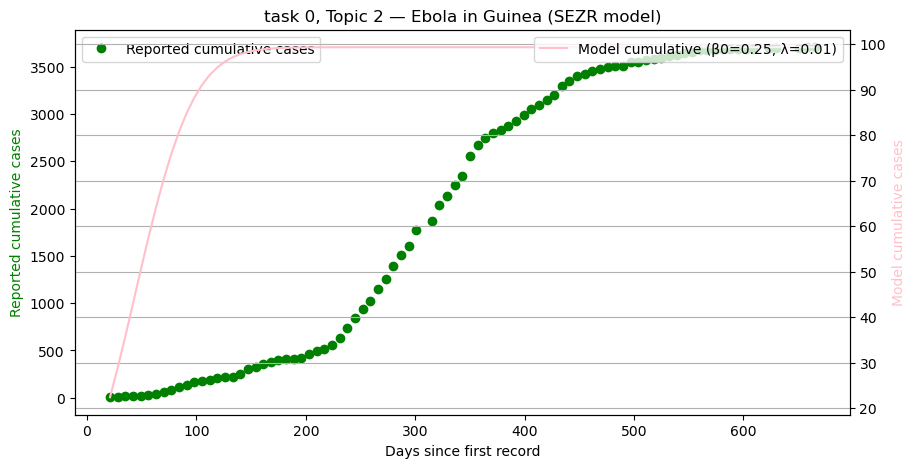

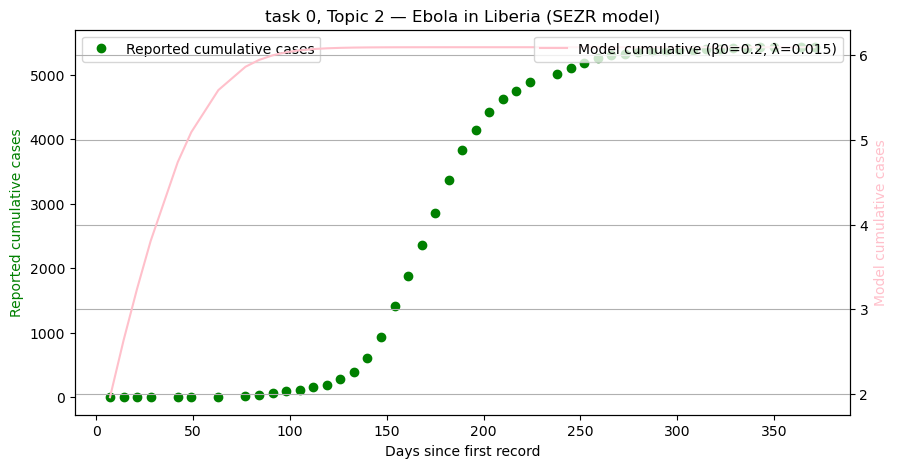

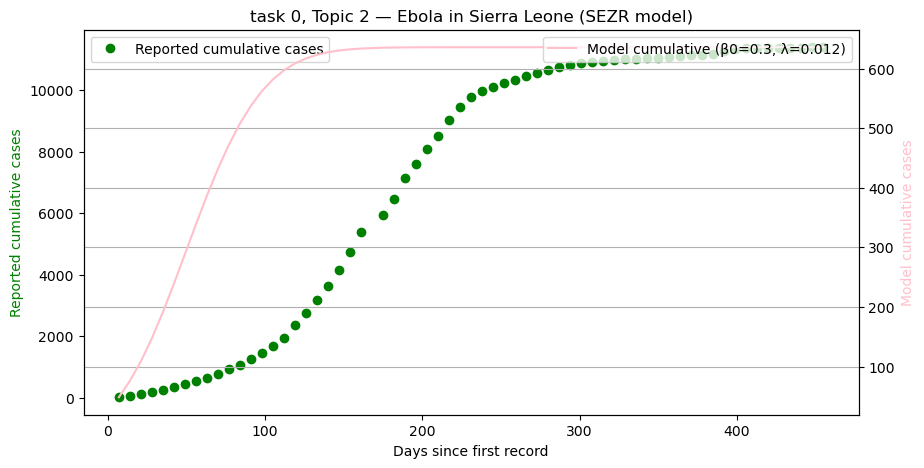

In [11]:
#task2_0: this is taken from project2 and modified for the three countries 
import pandas as pd
import math

#Parameters as shown in the project text 
N = 10_000_000
gamma = 1.0 / 7.0
sigma = 1.0 / 9.7

#SEZR model 
def sezr_rhs(y, t, beta0, lam):
    S, E, Z, R = y
    beta_t = beta0 * math.exp(-lam * t)
    dS = -beta_t * S * Z / N
    dE = beta_t * S * Z / N - sigma * E
    dZ = sigma * E - gamma * Z
    dR = gamma * Z
    return np.array([dS, dE, dZ, dR])

def rk4_step(f, y, t, dt, *args):
    k1 = f(y, t, *args)
    k2 = f(y + 0.5*dt*k1, t + 0.5*dt, *args)
    k3 = f(y + 0.5*dt*k2, t + 0.5*dt, *args)
    k4 = f(y + dt*k3, t + dt, *args)
    return y + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0


def integrate_sezr(beta0, lam, t_end, new_cases, dt=0.25):
    tgrid = np.arange(0, t_end+dt, dt)
    Z0 = max(1.0, new_cases[0])
    y0 = np.array([N - Z0, 0.0, Z0, 0.0])
    Y = np.zeros((len(tgrid), 4))
    Y[0] = y0
    for i in range(len(tgrid)-1):
        Y[i+1] = rk4_step(sezr_rhs, Y[i], tgrid[i], dt, beta0, lam)
        Y[i+1] = np.maximum(Y[i+1], 0)
    return tgrid, Y

#Files for the three countries
files = {
    "Guinea": "data/ebola_cases_guinea.dat",
    "Liberia": "data/ebola_cases_liberia.dat",
    "Sierra Leone": "data/ebola_cases_sierra_leone.dat"
}

#Manual parameters
params = {
    "Guinea": (0.25, 0.01),
    "Liberia": (0.20, 0.015),
    "Sierra Leone": (0.30, 0.012)
}

#Loop over countries
for country, fname in files.items():
    df = pd.read_csv(fname, sep=None, engine="python")
    days = pd.to_numeric(df.iloc[:,1], errors="coerce").values.astype(float)
    new_cases = pd.to_numeric(df.iloc[:,2], errors="coerce").fillna(0).values.astype(float)
    cum_cases = np.cumsum(new_cases)

    beta0, lam = params[country]
    tgrid, Y = integrate_sezr(beta0, lam, days[-1], new_cases)
    S = np.interp(days, tgrid, Y[:,0])
    cum_model = N - S

    #Plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()

    ax1.plot(days, cum_cases, "o", color="green", label="Reported cumulative cases")
    ax1.set_ylabel("Reported cumulative cases", color="green")

    ax2.plot(days, cum_model, "-", color="pink", label=f"Model cumulative (β0={beta0}, λ={lam})")
    ax2.set_ylabel("Model cumulative cases", color="pink")

    ax1.set_xlabel("Days since first record")
    ax1.set_title(f"task 0, Topic 2 — Ebola in {country} (SEZR model)")

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.grid(True)
    plt.show()

Working on: Guinea
days len: 89 cases len: 89


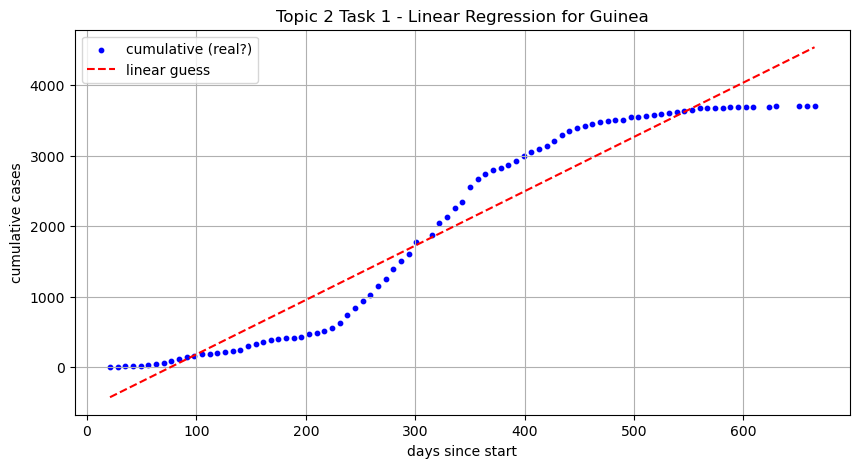

slope: 7.711
intercept: -589.07
Working on: Liberia
days len: 48 cases len: 48


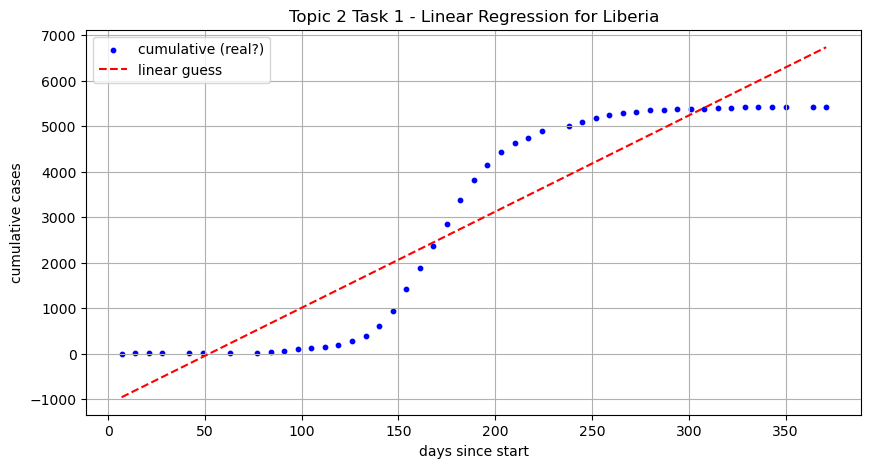

slope: 21.142
intercept: -1107.3
Working on: Sierra Leone
days len: 64 cases len: 64


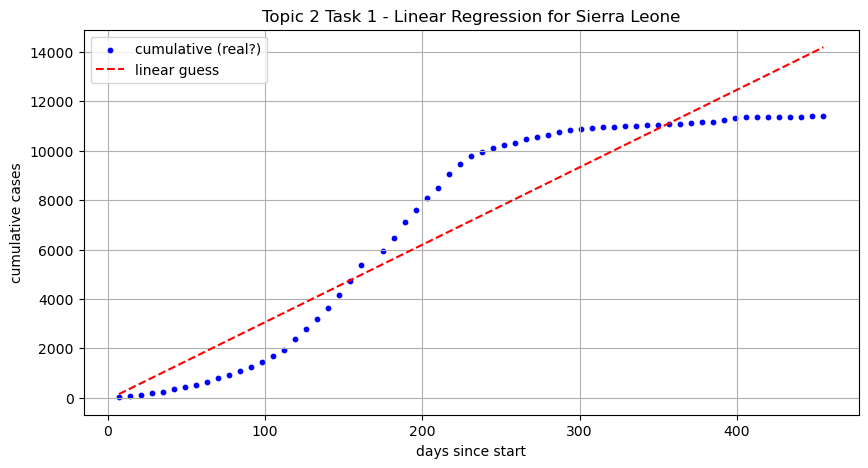

slope: 31.357
intercept: -75.535


'""\n#task:2_1\nfrom sklearn.linear_model import LinearRegression\n\nfor country, fname in files.items():\n    # Load data\n    df = pd.read_csv(fname, sep=None, engine="python")\n    days = pd.to_numeric(df.iloc[:,1], errors="coerce").values.astype(float)\n    new_cases = pd.to_numeric(df.iloc[:,2], errors="coerce").fillna(0).values.astype(float)\n    cum_cases = np.cumsum(new_cases)\n\n    # Reshape for sklearn\n    X = days.reshape(-1, 1)\n    y = cum_cases\n\n    # Fit linear regression\n    model = LinearRegression()\n    model.fit(X, y)\n    y_pred = model.predict(X)\n\n    # Plot\n    plt.figure(figsize=(10,5))\n    plt.scatter(days, cum_cases, color="blue", label="Reported cumulative cases")\n    plt.plot(days, y_pred, color="red", linestyle="--", label="Linear regression fit")\n\n    plt.xlabel("Days since first record")\n    plt.ylabel("Cumulative cases")\n    plt.title(f"Topic 2, Task 1 — Linear Regression for {country}")\n    plt.legend()\n    plt.grid(True)\n    plt.show()

In [15]:






# task:2_1

from sklearn.linear_model import LinearRegression


for ctry, fn in files.items():

    print("Working on:", ctry,  )   # just to know where I am

    # load the data?
    try:
        data = pd.read_csv(fn, sep=None, engine="python")   # fixes weird separators?
    except Exception as e:
        print("could not read file:", fn)
        print("error:", e)
        continue


    try:
        days_raw = data.iloc[:,1]
    except:
        print("file format looks strange for", fn)
        continue

    # convert to numbers
    days = pd.to_numeric(days_raw, errors="coerce")
    days = days.fillna(0)   
    days = days.values.astype(float)


    # new cases column 
    nc_raw = data.iloc[:,2]
    new_cases = pd.to_numeric(nc_raw, errors="coerce").fillna(0)
    new_cases = np.array(new_cases).astype(float)

    # cumulative sum
    cum_cases = np.cumsum(new_cases)

    # debug print
    print("days len:", len(days), "cases len:", len(cum_cases))

    # sklearn likes 2D arrays so reshaping 
    X = days.reshape(-1,1)
    y = cum_cases   

    # modeling
    model = LinearRegression()

    # trying to fit it
    try:
        model.fit(X, y)
    except Exception as err:
        print("model fit failed for", ctry, ":", err)
        continue

    # predictions
    try:
        y_pred = model.predict(X)
    except:
        print("prediction didn't work somehow")
        y_pred = y   # fallback so plot wont break


    # plot stuff 
    plt.figure(figsize=(10,5))

    plt.scatter(days, cum_cases, color="blue", s=10, label="cumulative (real?)")
    plt.plot(days, y_pred, "--", color="red", label="linear guess")

    plt.title("Topic 2 Task 1 - Linear Regression for " + str(ctry))
    plt.xlabel("days since start")
    plt.ylabel("cumulative cases")
    plt.grid(True)
    plt.legend()

    plt.show()

    # printing the slope/intercept 
    try:
        print("slope:", round(model.coef_[0], 3))
        print("intercept:", round(model.intercept_, 3))
    except:
        print("couldn't get slope/intercept lol")



















#by chatgpt 
"""""
#task:2_1
from sklearn.linear_model import LinearRegression

for country, fname in files.items():
    # Load data
    df = pd.read_csv(fname, sep=None, engine="python")
    days = pd.to_numeric(df.iloc[:,1], errors="coerce").values.astype(float)
    new_cases = pd.to_numeric(df.iloc[:,2], errors="coerce").fillna(0).values.astype(float)
    cum_cases = np.cumsum(new_cases)

    # Reshape for sklearn
    X = days.reshape(-1, 1)
    y = cum_cases

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Plot
    plt.figure(figsize=(10,5))
    plt.scatter(days, cum_cases, color="blue", label="Reported cumulative cases")
    plt.plot(days, y_pred, color="red", linestyle="--", label="Linear regression fit")

    plt.xlabel("Days since first record")
    plt.ylabel("Cumulative cases")
    plt.title(f"Topic 2, Task 1 — Linear Regression for {country}")
    plt.legend()
    plt.grid(True)
    plt.show()

    
 # Print coefficients
    print(f"{country}: slope={model.coef_[0]:.2f}, intercept={model.intercept_:.2f}")

    """


 working on: Guinea
len days: 89  | len cum: 89


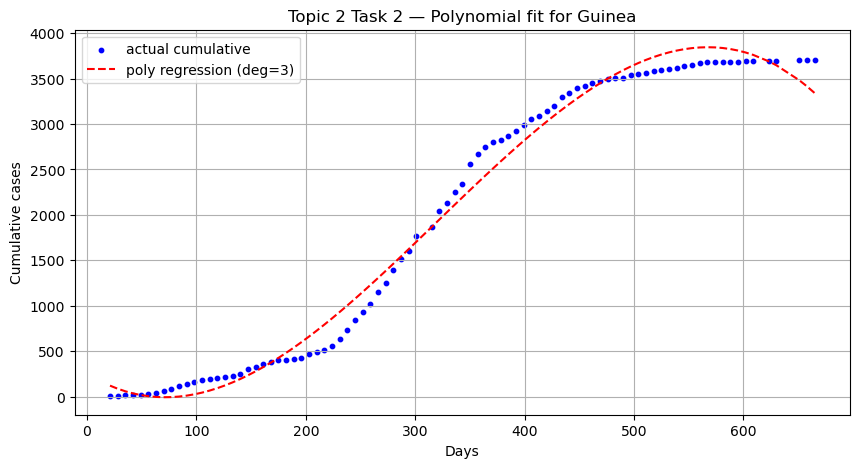


 working on: Liberia
len days: 48  | len cum: 48


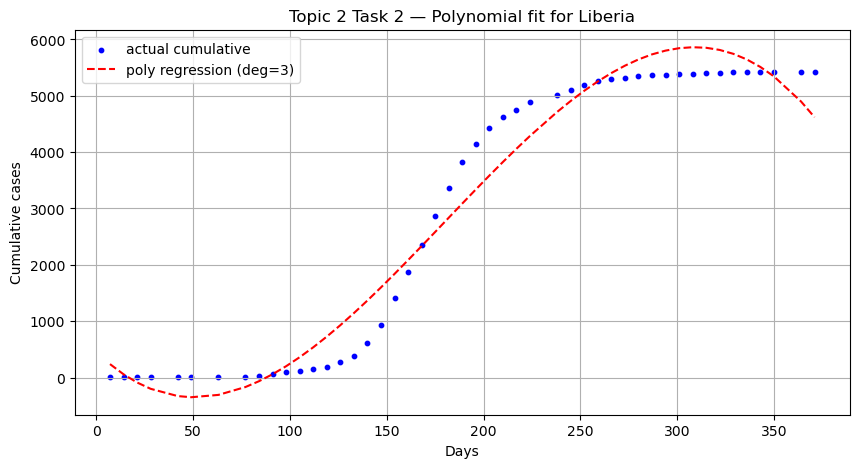


 working on: Sierra Leone
len days: 64  | len cum: 64


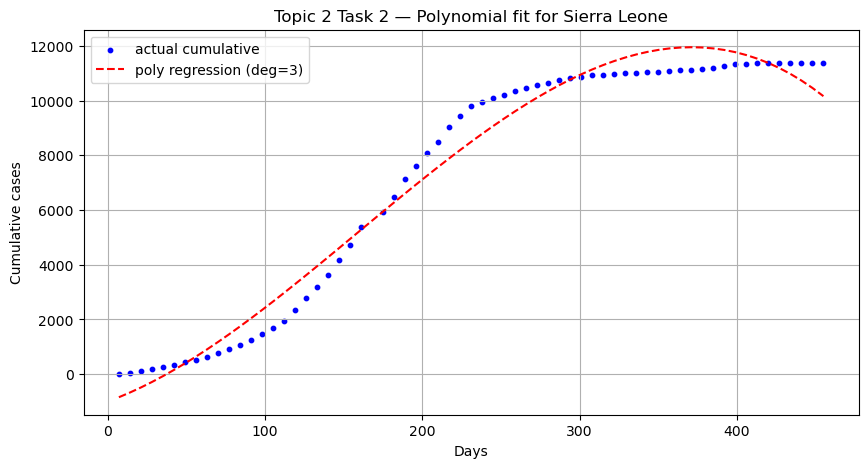

'\n#task:2_2\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\n\n\n#Polynomial degree\ndegree = 3\n\nfor country, fname in files.items():\n    # Load data\n    df = pd.read_csv(fname, sep=None, engine="python")\n    days = pd.to_numeric(df.iloc[:,1], errors="coerce").values.astype(float)\n    new_cases = pd.to_numeric(df.iloc[:,2], errors="coerce").fillna(0).values.astype(float)\n    cum_cases = np.cumsum(new_cases)\n\n    # Reshape for sklearn\n    X = days.reshape(-1, 1)\n    y = cum_cases\n\n    # Polynomial regression pipeline\n    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())\n    model.fit(X, y)\n    y_pred = model.predict(X)\n\n    # Plot\n    plt.figure(figsize=(10,5))\n    plt.scatter(days, cum_cases, color="blue", label="Reported cumulative cases")\n    plt.plot(days, y_pred, color="red", linestyle="--", label=f"Polynomial regression (degree={degree})")\n\n    plt.xlabel("Days since first record")\n    p

In [17]:
# task:2_2


from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


poly_deg = 3   # trying degree 3


for ctry, file_name in files.items():

    print("\n working on:", ctry, )

    # reading file 
    try:
        df = pd.read_csv(file_name, sep=None, engine="python")
    except Exception as e:
        print("couldn't open file:", file_name)
        print("error:", e)
        continue

    
    try:
        days_tmp = df.iloc[:,1]
    except:
        print("column missing in file:", file_name)
        continue

    days = pd.to_numeric(days_tmp, errors="coerce")
    days = days.fillna(0)    
    days = days.values.astype(float)

    # new cases
    new_tmp = df.iloc[:,2]
    new_cases = pd.to_numeric(new_tmp, errors="coerce").fillna(0)
    new_cases = np.array(new_cases).astype(float)

    cum_cases = np.cumsum(new_cases)   

    # checking lengths
    print("len days:", len(days), " | len cum:", len(cum_cases))

    # reshaping AGAIN cuz sklearn complains
    X = days.reshape(-1,1)
    y = cum_cases

    # polynomial model thing
    try:
        model = make_pipeline(PolynomialFeatures(poly_deg), LinearRegression())
        model.fit(X, y)
    except Exception as err:
        print("model failed for", ctry, "-->", err)
        continue

    try:
        y_pred = model.predict(X)
    except:
        print("prediction failed")
        y_pred = y   # fallback so we still get a plot


    # plotting 
    plt.figure(figsize=(10,5))

    plt.scatter(days, cum_cases, label="actual cumulative", color="blue", s=10)
    plt.plot(days, y_pred, "--", color="red",
             label="poly regression (deg=" + str(poly_deg) + ")")

    plt.title("Topic 2 Task 2 — Polynomial fit for " + str(ctry))
    plt.xlabel("Days")
    plt.ylabel("Cumulative cases")
    plt.grid(True)
    plt.legend()
    plt.show()







































"""""""""
#task:2_2
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


#Polynomial degree
degree = 3

for country, fname in files.items():
    # Load data
    df = pd.read_csv(fname, sep=None, engine="python")
    days = pd.to_numeric(df.iloc[:,1], errors="coerce").values.astype(float)
    new_cases = pd.to_numeric(df.iloc[:,2], errors="coerce").fillna(0).values.astype(float)
    cum_cases = np.cumsum(new_cases)

    # Reshape for sklearn
    X = days.reshape(-1, 1)
    y = cum_cases

    # Polynomial regression pipeline
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    y_pred = model.predict(X)

    # Plot
    plt.figure(figsize=(10,5))
    plt.scatter(days, cum_cases, color="blue", label="Reported cumulative cases")
    plt.plot(days, y_pred, color="red", linestyle="--", label=f"Polynomial regression (degree={degree})")

    plt.xlabel("Days since first record")
    plt.ylabel("Cumulative cases")
    plt.title(f"Topic 2, Task 2 — Polynomial Regression for {country}")
    plt.legend()
    plt.grid(True)
    plt.show()

    """

The first graph shows the number of cases of ebola reported in Guinea, with the x-axis representing the number of days, and the y-axis showing the amount of cases. The second graph showcases Liberia, while the third shows Sierra Leone. 

Task 1:

We will train up an algorithm to use linear regression method on the data of the three countiress. Linear regression is one of the most used methods for modelling the relation between multiple variables [2]. 

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression 
import matplotlib.pyplot as plt

# provide data to work with
data_files = {
    "Guinea" : "ebola_models/ebola_cases_guinea.dat",
    "Liberia" : "ebola_models/ebola_cases_liberia.dat",
    "Sierra Leone" : "ebola_models/ebola_cases_sierra_leone.dat"
} 

cumulative_data = {} # Dictionary for cumulative cases
#loop through each country's data file to generate plots 
for country, file in data_files.items():
    #load the data
    data = file
    try:
         new_cases = np.loadtxt(file, usecols=2)
         cumulative_data[country] = np.cumsum(new_cases) 
    except FileNotFoundError:
            print(f"File {file} not found. Skipping {country}.")
            continue
    
    except Exception as e:
        print(f"An error occurred while loading {file}: {e}")
        continue


for country, cumulative_cases in cumulative_data.items():

  x = np.arange(len(cumulative_cases)).reshape((-1, 1))
  y = cumulative_cases

# create a regression model and fit it with existing data.
  model = LinearRegression()
  model.fit(x, y)

  y_pred = model.predict(x) # Prediction of cumulative cass

  plt.figure(figsize=(10,5))
  plt.plot(x, y, label='cumulative cases', marker='o')
  plt.plot(x, y_pred, label='linear regression prediction', color='red', linewidth=2)
  plt.xlabel('number of days')
  plt.ylabel('predicted cumulative cases')
  plt.legend()
  plt.show


File ebola_models/ebola_cases_guinea.dat not found. Skipping Guinea.
File ebola_models/ebola_cases_liberia.dat not found. Skipping Liberia.
File ebola_models/ebola_cases_sierra_leone.dat not found. Skipping Sierra Leone.


Task 2:

The method we will implement is the polynomial regression technique, which is more fitting for analysing complex system like the evoultion of the epidemic outbreak [3]. Where as linear regression is more suitable for variables with linear relations. 

In [19]:
import numpy as np
import matplotlib
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

data_files = {
    "Guinea" : "ebola_models/ebola_cases_guinea.dat",
    "Liberia" : "ebola_models/ebola_cases_liberia.dat",
    "Sierra Leone" : "ebola_models/ebola_cases_sierra_leone.dat"
} 

cumulative_data = {}

for country, file in data_files.items():
    #load the data
    data = f   ile
    try:
         new_cases = np.loadtxt(file, usecols=2)
         cumulative_data[country] = np.cumsum(new_cases) 
    except FileNotFoundError:
            print(f"File {file} not found. Skipping {country}.")
            continue
    
    except Exception as e:
        print(f"An error occurred while loading {file}: {e}")
        continue

for country, cumulative_cases in cumulative_data.items():

  x = np.arange(len(cumulative_cases)).reshape((-1, 1))
  y = cumulative_cases
 

# creating a polynomial regression model and training it:
degree = 3
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(x, y)
y_poly_pred = poly_model.predict(x)

plt.scatter(x, y, color='blue', label='Actual cumulative cases')
plt.plot(x, y_poly_pred, color='red', linewidth=2, label=f'Polynomial Degree {degree}')
plt.xlabel('number of days')
plt.ylabel('cumulative cases')
plt.title('polynomial regression')
plt.legend()
plt.show()


SyntaxError: invalid syntax (1967838278.py, line 17)

Task 3:


In [29]:
# We will be adding libraires like sklearn model for dividing the data for training and testing, and tensorflow. 

import numpy as np
import matplotlib as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

data_files = {
    "Guinea" : "data/ebola_cases_guinea.dat",
    "Liberia" : "data/ebola_cases_liberia.dat",
    "Sierra Leone" : "data/ebola_cases_sierra_leone.dat"
} 

cumulative_data = {}

for country, file in data_files.items():
    #load the data
    data = file
    try:
         new_cases = np.loadtxt(file, usecols=2)
         cumulative_data[country] = np.cumsum(new_cases) 
    except FileNotFoundError:
            print(f"File {file} not found. Skipping {country}.")
            continue
    
    except Exception as e:
        print(f"An error occurred while loading {file}: {e}")
        continue

for country, cumulative_cases in cumulative_data.items():

  x = np.arange(len(cumulative_cases)).reshape((-1, 1))
  y = cumulative_cases



ModuleNotFoundError: No module named 'tensorflow'

Task 4:

Task 5:

Self Reflection:

Baraa: At the beginning of this project, I used ChatGPT mainly to get an idea of what the final outputs should look like. I generated some code with ChatGPT, but it was never meant to be my actual solution. I only wanted a reference so I could compare my results later and check if I was going in the right direction. The code ChatGPT produced was also quite complicated for me to understand, so I didn’t rely on it or build on top of it.
Instead, I decided to write everything myself from scratch. I included the ChatGPT-generated code in the project just to show what I was comparing my work to, not because I used it. By recreating all the tasks on my own, I could make my code simpler and more understandable for my level.
I also opened a GitHub repository and added all the data files, so everything is organized and easy to access. After that, I completed Task 1_0 and 1_1 and 1_2 and  1_5 and Tasks 2_0, 2_1, and 2_2 fully on my own. Working through them manually helped me understand the process—reading data, doing the calculations, plotting graphs, and applying the regression methods.
Overall, using ChatGPT as a visual example of expected results was helpful, but rewriting the project myself taught me much more. It helped me see the difference between AI-generated solutions and my own understanding, and it made me more confident in the work I produced.

Tom: Combining what we did with the previous assignment, I used my previous work at ELE610 to convert it to process the milkyway galaxy picture for tasks 2, 3, 4, 6 and 7 in topic 1. I also had to look up the internet on how to use basic processing techniques in order to get myself through. I tried to actually make the code work and make it as easily understandable as possible. Once the extraction worked to actually get the picture in place, the remaining of the tasks came pretty forward in what to do. Learning to apply K-means clustering also helped me understand the value of normalization and subsampling. Working through them allowed me to learn image handling, and how processing tools, and how verifying each process is important before thinking the final result is correct.

Conclusion: 

Usage of AI: ChatGPT was used as a guideline to solve task 2 of topic 2

## References

[1] https://www.ibm.com/think/topics/machine-learning

[2] https://realpython.com/linear-regression-in-python/#linear-regression

[3] https://www.kaggle.com/code/lxlz1986/polynomial-regression-in-scikit-learn

[4] Milky Way Plot Documentation (Face-on View).  
https://milkyway-plot.readthedocs.io/en/stable/matplotlib_faceon.html

[5] Image processing in python https://www.geeksforgeeks.org/python/image-processing-in-python/